# Image Classification

In [19]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms,models,datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image
warnings.filterwarnings("ignore")

### Import Training and Validation Image

In [2]:
data_dir='./flower_data/'
train_dir=data_dir+'/train'
valid_dir=data_dir+'/valid'

### Data Pre-Processsing

In [3]:
# Data Augmentation
data_transforms={
    'train':transforms.Compose([transforms.RandomRotation(45),                  # Random Rotation between -45 to +45 degree
    transforms.CenterCrop(224),                                                 # Cut from Center, VGG, Resnet
    transforms.RandomHorizontalFlip(p=0.5),                                     # Random Horizontal Flip
    transforms.RandomVerticalFlip(p=0.5),                                       # Random Vertical Flip
    transforms.ColorJitter(brightness=0.2,contrast=0.1,saturation=0.1,hue=0.1), # brightness=0.2,contrast=0.1,saturation=0.1,hue=0.1
    transforms.RandomGrayscale(p=0.025),                                        # Probability to get Grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.458,0.456,0.406],[0.229,0.224,0.225])               # Mean and Var, make sure our data fit other model like VGG Resnet
    ]),
    'valid':transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),                                                 # Cut from Center
    transforms.ToTensor(),
    transforms.Normalize([0.458,0.456,0.406],[0.229,0.224,0.225])               # Mean and Var
    ])
}

In [4]:
batch_size=8
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train', 'valid']} # root=os.path.join(data_dir,x), transforms=data_transforms[x], in ['train', 'valid']
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batch_size,shuffle=True) for x in ['train', 'valid']}
dataset_sizes={x:len(image_datasets[x]) for x in ['train', 'valid']}
class_name=image_datasets['train'].classes

with open ('cat_to_name.json','r') as f: # Read name of flower
    cat_to_name=json.load(f)


In [5]:
def im_convert(tensor):
    '''Convert tensor data type back to noraml image data type'''
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229,0.224,0.225))+np.array((0.458,0.456,0.406))
    image = image.clip(0,1)
    return image

### Load model from models, and use trained weights and bias

In [6]:
model_name='resnet' # Can choose from ['resnet','alexnet','vgg',squeezenet','densenet','inception']
feature_extract=True

train_on_gpu=torch.cuda.is_available()

# Check for GPU if available use GPU
if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

CUDA is not available. Training on CPU


In [7]:
# Set the layers that don't need modified
def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad=False

In [8]:
model_ft=models.resnet152() # Load Resnet 152
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Example from pytorch

In [9]:
def initialize_model(model_name,num_classes, feature_extract,use_pretrained=True):
    # Choose suitable model, There are some different for different model
    model_ft=None
    input_size=0

    if model_name=='resnet':
        '''Resnet152'''
        model_ft=models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.fc.in_features
        model_ft.fc=nn.Sequential(nn.Linear(num_ftrs,102),
                                  nn.LogSoftmax(dim=1))
        input_size=224
    elif model_name=='alexnet':
        '''Alexnet'''
        model_ft=models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='vgg':
        '''VGG11_bn'''
        model_ft=models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier[6].in_features
        model_ft.classifier[6]=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='squeezenet':
        '''Squeezenet'''
        model_ft=models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs.classifier[1]=nn.Conv2d(512,num_classes,kernel_size=(1,1),stride=(1,1))
        model_ft.num_classes=num_classes
        input_size=224
    elif model_name=='densenet':
        '''Densenet'''
        model_ft=models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs=model_ft.classifier.in_features
        model_ft.classifier=nn.Linear(num_ftrs,num_classes)
        input_size=224
    elif model_name=='inception':
        '''Inception v3
            Be careful, expects (299,299) sized images and has auxiliary output
        '''
        model_ft=models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft,feature_extract)
        # Handle the auxilary net
        num_ftrs=model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc=nn.Linear(num_ftrs,num_classes)
        # Handle the primary net
        num_ftrs=model_ft.fc.in_features
        model_ft.fc=nn.Linear(num_ftrs,num_classes)
        input_size=299

    else:
        print('Invalid model name, exiting')
        exit()

    return model_ft,input_size

In [10]:
model_ft,input_size=initialize_model(model_name,102,feature_extract,use_pretrained=True)

model_ft=model_ft.to(device)

# Save model
filename='checkpoint.pth'

# Whether train all the layer
params_to_update=model_ft.parameters()
print('Params to lean:')
if feature_extract:
    params_to_update=[]
    for name,param in model_ft.named_parameters():
        if param.requires_grad==True:
            params_to_update.append(param)
            print('\t',name)
else:
    for name,param, in model_ft.named_parameters():
        if param.requires_grad==True:
            print('\t',name)

Params to lean:
	 fc.0.weight
	 fc.0.bias


In [11]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Optimizer Settings

In [12]:
optimizer_ft=optim.Adam(params_to_update,lr=1e-2)
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1) # Learning Rate for every 7 epoch decrease to 1/10
# In last layer we have LogSoftmax(), SO we can not use nn.CrossEntropyLoss() any more, nn.CrossEntropyLoss equal to LogSoftmax() plus nn.NLLLoss.
criterion=nn.NLLLoss()

### Training module

In [13]:
def train_model (model,dataloaders,criterion,optimizer,num_epochs=25,is_inception=False,filename=filename):
    since=time.time()
    best_acc=0
    '''
    checkpoint=torch.load(filename)
    best_acc=checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx=checkpoint['mapping']
    '''
    model.to(device)

    val_acc_history=[]
    train_acc_history=[]
    train_losses=[]
    valid_losses=[]
    LRs=[optimizer.param_groups[0]['lr']]

    best_model_wts=copy.deepcopy(model.state_dict())

    for epoch in range (num_epochs):
        print('Epoch{}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # Train and validation
        for phase in ['train','valid']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            
            running_loss=0.0
            running_corrects=0

            # Iterate for every data
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)

                optimizer.zero_grad()

                # Update Gradient only when training
                with torch.set_grad_enabled(phase=='train'):
                    if is_inception and phase=='train':
                        outputs,aux_outputs=model(input)
                        loss1=criterion(outputs,labels)
                        loss2=criterion(aux_outputs,labels)
                        loss=loss1+0.4*loss2
                    else: # resnet use here
                        outputs=model(inputs)
                        loss=criterion(outputs,labels)
                    
                    _,preds=torch.max(outputs,1)
                    # Update Gradient
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            
            epoch_loss=running_loss/len(dataloaders[phase].dataset)
            epoch_acc=running_corrects.double()/len(dataloaders[phase].dataset)

            time_elapsed=time.time()-since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))

            if phase=='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                state={
                    'state_dict':model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict()
                }
                torch.save(state,filename)
            if phase=='valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase=='train':
                train_acc_history.append(epoch_loss)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate :{:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val ACC: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model,val_acc_history,train_acc_history,valid_losses,train_losses,LRs
                    


In [14]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs=train_model (model_ft,dataloaders,
                                                                         criterion,optimizer_ft,
                                                                         num_epochs=20,
                                                                         is_inception=(model_name=='inception'))

Epoch0/19
----------
Time elapsed 6m 34s
train Loss: 10.4628 Acc: 0.3135
Time elapsed 7m 13s
valid Loss: 13.8247 Acc: 0.3998
Optimizer learning rate :0.0010000

Epoch1/19
----------
Time elapsed 13m 37s
train Loss: 2.7460 Acc: 0.6862
Time elapsed 14m 15s
valid Loss: 3.5478 Acc: 0.6394
Optimizer learning rate :0.0100000

Epoch2/19
----------
Time elapsed 20m 35s
train Loss: 9.7252 Acc: 0.4753
Time elapsed 21m 13s
valid Loss: 16.1340 Acc: 0.3680
Optimizer learning rate :0.0001000

Epoch3/19
----------
Time elapsed 27m 26s
train Loss: 4.7550 Acc: 0.6738
Time elapsed 28m 4s
valid Loss: 6.7166 Acc: 0.6002
Optimizer learning rate :0.0100000

Epoch4/19
----------
Time elapsed 34m 18s
train Loss: 9.2106 Acc: 0.5531
Time elapsed 34m 55s
valid Loss: 11.9565 Acc: 0.5489
Optimizer learning rate :0.0010000

Epoch5/19
----------
Time elapsed 41m 10s
train Loss: 3.0851 Acc: 0.7627
Time elapsed 41m 49s
valid Loss: 5.6093 Acc: 0.6919
Optimizer learning rate :0.0100000

Epoch6/19
----------
Time elapsed

### Continue training for other layer

In [16]:
for param in model_ft.parameters():
    param.requires_grad=True

# Continue training for all parameter, with a smaller LR make sure that don't update too much 
optimizer=optim.Adam(params_to_update,lr=1e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

criterion=nn.NLLLoss()

In [17]:
# Load the checkpoint
checkpoint=torch.load(filename)
best_acc=checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [18]:
model_ft,val_acc_history,train_acc_history,valid_losses,train_losses,LRs=train_model (model_ft,dataloaders,
                                                                         criterion,optimizer,
                                                                         num_epochs=10,
                                                                         is_inception=(model_name=='inception'))

Epoch0/9
----------
Time elapsed 18m 12s
train Loss: 2.7281 Acc: 0.8225
Time elapsed 18m 60s
valid Loss: 6.8872 Acc: 0.7200
Optimizer learning rate :0.0010000

Epoch1/9
----------
Time elapsed 37m 25s
train Loss: 2.5877 Acc: 0.8254
Time elapsed 38m 7s
valid Loss: 6.8211 Acc: 0.7372
Optimizer learning rate :0.0010000

Epoch2/9
----------
Time elapsed 56m 17s
train Loss: 2.5286 Acc: 0.8275
Time elapsed 56m 58s
valid Loss: 7.4051 Acc: 0.7139
Optimizer learning rate :0.0010000

Epoch3/9
----------
Time elapsed 75m 16s
train Loss: 2.5768 Acc: 0.8249
Time elapsed 76m 4s
valid Loss: 5.8619 Acc: 0.7518
Optimizer learning rate :0.0010000

Epoch4/9
----------
Time elapsed 94m 2s
train Loss: 2.3367 Acc: 0.8349
Time elapsed 94m 47s
valid Loss: 5.5735 Acc: 0.7641
Optimizer learning rate :0.0010000

Epoch5/9
----------
Time elapsed 113m 6s
train Loss: 2.3572 Acc: 0.8356
Time elapsed 113m 54s
valid Loss: 6.5775 Acc: 0.7262
Optimizer learning rate :0.0010000

Epoch6/9
----------
Time elapsed 132m 14s


### Test model

In [21]:
model_ft,input_size=initialize_model(model_name,102,feature_extract,use_pretrained=True)
model_ft=model_ft.to(device)
filename='checkpoint.pth'

# Load model
checkpoint=torch.load(filename)
best_acc=checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Test data pre-processing

In [22]:
def process_image(image_path):
    img=Image.open(image_path)
    # Resize and thumbnail can only make image smaller
    if img.size[0]>img.size[1]:
        img.thumbnail((10000,256))
    else:
        img.thumbnail((256,10000))
    
    left_margin=(img.width-224)/2
    bottom_margin=(img.height-224)/2
    right_margin=left_margin+224
    top_margin=bottom_margin+224
    img=img.crop((left_margin,bottom_margin,right_margin,top_margin))

    img=np.array(img)/255
    mean=np.array([0.485,0.456,0.406]) # Provided mean
    std=np.array([0.229,0.224,0.225]) # Provided std
    img=(img-mean)/std
    
    img=img.transpose((2,0,1))

    return img

In [23]:
def imshow (image,ax=None,title=None):
    if ax is None:
        fig,ax=plt.subplots()
    
    image=np.array(image).transpose((1,2,0))

    mean=np.array([0.485,0.456,0.406]) # Provided mean
    std=np.array([0.229,0.224,0.225]) # Provided std
    image=std*image+mean
    image=np.clip(image,0,1)

    ax.imshow(image)
    ax.set_title(title)

    return ax

<AxesSubplot: >

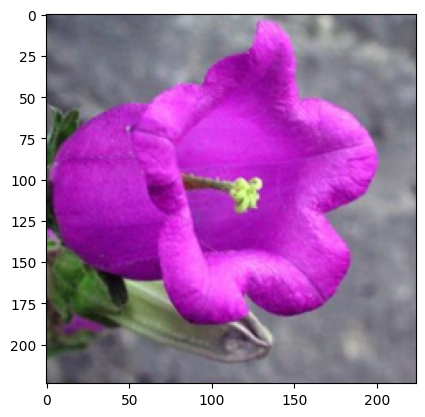

In [25]:
image_path='image_06621.jpg'
img=process_image(image_path)
imshow(img)

### Take a batch

In [28]:
dataiter=iter(dataloaders['valid'])
images,labels=next(dataiter)

model_ft.eval()

if train_on_gpu:
    output=model_ft(images.cuda())
else:
    output=model_ft(images)

output.shape

torch.Size([8, 102])

### Get one with highest probability

In [29]:
_,preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([89, 71,  3, 17, 63, 71, 96, 44])

### Show predict result

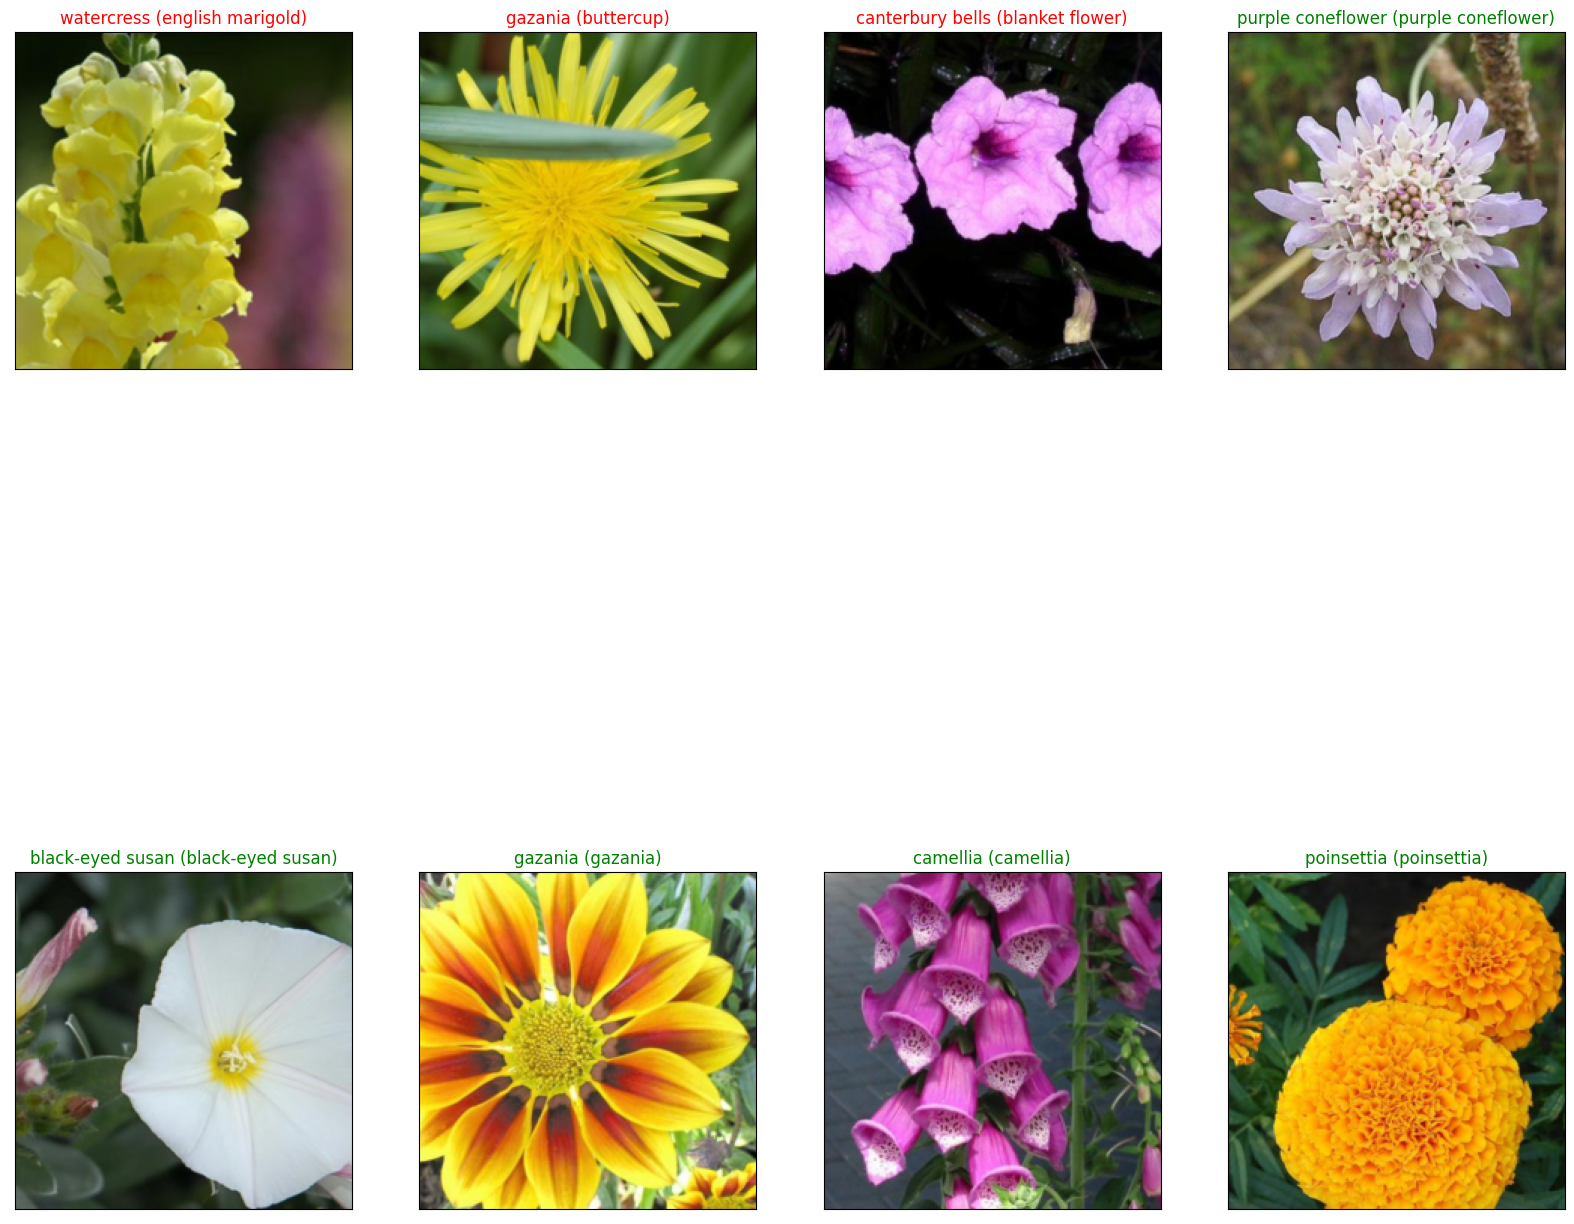

In [30]:
fig=plt.figure(figsize=(20,20))
columns=4
rows=2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows,columns,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title('{} ({})'.format(cat_to_name[str(preds[idx])],cat_to_name[str(labels[idx].item())]),
                 color=('green' if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else 'red'))
plt.show()